## SYMA : RecSys Challenge 2022

Authors:

- Victor Simonin
- Alexandre Lemonnier
- Sarah Gutierez
- Alexandre Poignant

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from keras import callbacks, layers, models, Sequential
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tqdm import tqdm

np.random.seed = 42
import warnings
warnings.filterwarnings("ignore")

2022-07-17 19:52:03.562268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-17 19:52:03.562317: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Loading data

`candidate_items.csv`: contains all the items available

In [2]:
candidates = pd.read_csv('./data/candidate_items.csv')
candidates

,item_id
0,4
1,8
2,9
3,19
4,20
...,...
4985,28128
4986,28131
4987,28132
4988,28133


`item_features.csv`: contains all the features of each item

In [3]:
items = pd.read_csv('./data/item_features.csv')
items

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


`train_purchases.csv`: contains all the purchases that occurred at the end of a session.

In [4]:
train_purchases = pd.read_csv('data/train_purchases.csv', dtype={'session_id': int, 'item_id': int, 'date':object})
train_purchases

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114
...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464
999996,4439990,8786,2020-08-22 14:28:22.382
999997,4439994,21630,2020-11-27 20:10:28.961
999998,4439999,16962,2020-11-27 11:01:41.356


`train_sessions.csv`: contains all the items viewed in a session for each session_id

In [5]:
train_sessions = pd.read_csv('data/train_sessions.csv', dtype={'session_id': int, 'item_id': int, 'date':object})
train_sessions

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186


`test_leaderboard_sessions`: contains the input sessions for the leader-board

In [6]:
test_leaderboard_sessions = pd.read_csv('./data/test_leaderboard_sessions.csv', dtype={'session_id': int, 'item_id': int, 'date':object})
test_leaderboard_sessions

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


# Data analysis

Items are represented in a sparse format with the id of the feature and its value. We have no information on whether or not it is categorical or numerical, or the number of features.  
We want to explore them a little bit and find a compact representation.

First we want to know the coverage of each feature:

<AxesSubplot:title={'center':'Feature Category coverage by ID'}, xlabel='Feature Category ID', ylabel='Values count'>

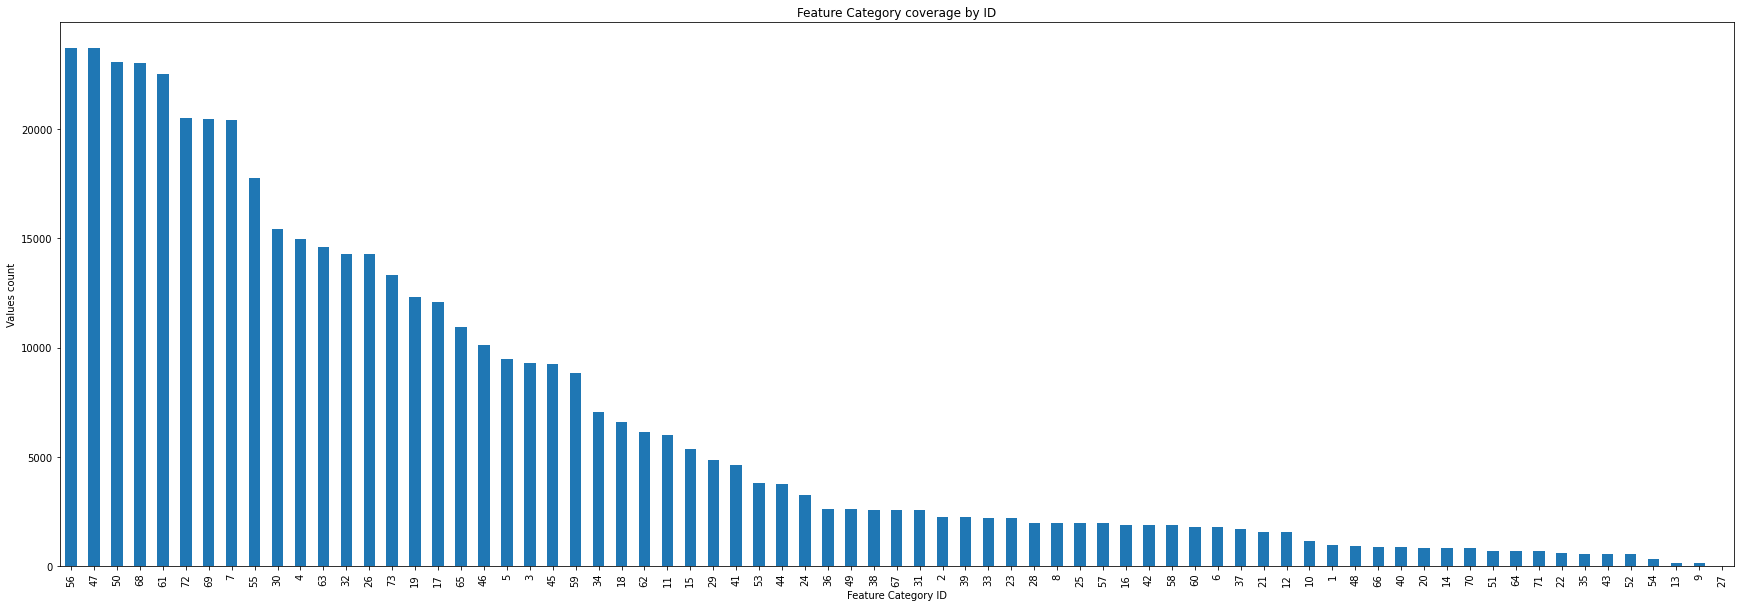

In [7]:
coverage = items['feature_category_id'].sort_values(ascending=False).value_counts(sort=True)
coverage.plot(
    kind='bar',
    figsize=(30, 10),
    xlabel='Feature Category ID',
    ylabel='Values count',
    title='Feature Category coverage by ID')

73 features is not that much, let's see how each of them look. Let's display the counts / min / max / std for each feature. 

In [8]:
items.drop(columns='item_id').groupby('feature_category_id', sort=False).describe()

feature_value_id                                        \
                               count        mean         std    min    25%   
feature_category_id                                                          
56                           23691.0  360.189861  107.438375    1.0  365.0   
62                            6148.0  639.005856  318.478435   15.0  801.0   
68                           23038.0  443.496050  230.800434   10.0  351.0   
33                            2221.0  328.501126  364.058791   36.0   36.0   
72                           20499.0  191.034392  218.286790    7.0   75.0   
...                              ...         ...         ...    ...    ...   
66                             877.0  869.124287   72.171785  264.0  886.0   
40                             877.0  594.037628  204.118748   49.0  449.0   
9                              137.0  223.635036   77.537171  175.0  175.0   
13                             137.0  580.554745  206.876701  252.0  252.0   
27                               1.0  423.000000         NaN  423.0  423.0   

                                          
                       50%    75%    max  
feature_category_id                       
56                   365.0  365.0  868.0  
62                   801.0  801.0  896.0  
68                   373.0  702.0  903.0  
33                    36.0  764.0  873.0  
72                    75.0  263.0  883.0  
...                    ...    ...    ...  
66                   886.0  886.0  886.0  
40                   717.0  717.0  717.0  
9                    190.0  190.0  369.0  
13                   698.0  698.0  905.0  
27                   423.0  423.0  423.0  

[73 rows x 8 columns]

We can see that the feature 27 is useless, because it has all the time the same value and appears only one time, we decided to remove it:

In [9]:
items.drop(items[items['feature_category_id'] == 27].index, inplace=True)
items

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


Let's see how the sessions are represented in the `train_sessions` dataset:

<AxesSubplot:title={'center':"Count of sessions' ID per range"}, xlabel='Ranges of count', ylabel="Number of sessions' ID per range">

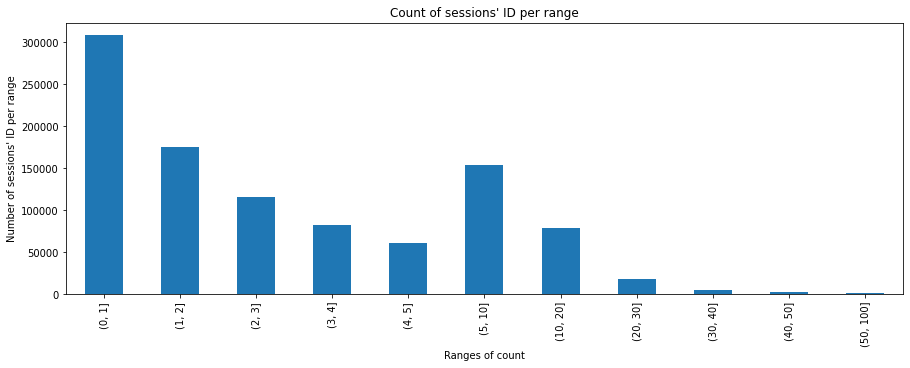

In [10]:
pd.cut(list(train_sessions['session_id'].value_counts()),
       bins=[0,1,2,3,4,5,10,20,30,40,50,100]).value_counts().plot(kind='bar',
                                                                      figsize=(15, 5), 
                                                                      xlabel='Ranges of count',
                                                                      ylabel='Number of sessions\' ID per range',
                                                                      title='Count of sessions\' ID per range')

We can see that most of the `session_id` in `train_sessions` dataset visit only one item.

Let's see some statistics about the `train_purchases` dataset:

In [11]:
train_purchases['session_id'].value_counts().describe()

count    1000000.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: session_id, dtype: float64

We can see that there is only one item bought by `session_id`

We will only work with the 15 most represented features for our recommmendation systems algorithms.

In [12]:
features = list(coverage.index[:15])

In [13]:
items[items['feature_category_id'].isin(features)]

,item_id,feature_category_id,feature_value_id
0,2,56,365
2,2,68,351
4,2,72,75
7,2,50,76
8,2,61,462
...,...,...,...
471745,28143,72,371
471746,28143,68,351
471747,28143,55,390
471749,28143,73,91


# Embeddings items

If 73 features is not a lot, it is still a big number. We have to preprocessed the data into a set of embeddings without sparse format because most ML algorithm do not handle sparse. We use TruncatedSVD from scikit-learn with n_components = 12 and compute embeddings for the items.

In [14]:
coo_mat = sparse.coo_matrix((items["feature_value_id"], (items["item_id"], items["feature_category_id"])))
coo_mat

<28144x74 sparse matrix of type '<class 'numpy.int64'>'
	with 471750 stored elements in COOrdinate format>

In [15]:
n_components = 12
svd = TruncatedSVD(n_components)
embeddings_items = pd.DataFrame(svd.fit_transform(coo_mat))
embeddings_items.shape

(28144, 12)

You now have a matrix of dimension (28144, n_components) representing the items.

In [16]:
embeddings_items

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,794.680184,377.343645,-303.561673,669.612883,487.114887,31.148108,179.061715,297.331501,-153.002480,-448.524519,-81.569077,46.319596
3,2387.218101,-924.921011,161.342832,-448.550066,-36.610209,-508.698241,-261.136985,140.741311,-136.550730,-86.512242,102.699247,-516.664856
4,2304.639154,-837.402436,194.342674,-143.934263,-183.789389,3.303303,190.626345,-170.484805,-157.353376,-63.418494,-371.104993,53.195475
...,...,...,...,...,...,...,...,...,...,...,...,...
28139,2496.719059,-681.709968,127.865500,94.363968,-141.323280,830.502387,-244.846888,-96.744653,367.212022,38.584500,-408.257421,-30.232682
28140,747.063373,532.023459,-1458.557348,-589.887973,-396.119748,6.411864,44.170371,-82.434265,-223.266810,-183.538224,80.635599,-77.865949
28141,2039.201872,-664.322599,27.056811,-712.698213,16.570247,17.019049,252.183792,-164.743081,-58.173656,-298.749091,-73.553402,-138.681975
28142,1472.569195,356.499022,-347.940103,38.524869,879.685880,493.894900,56.289651,12.011089,227.103561,-35.929873,-236.977027,-303.093626


We need to remove some object otherwise we could be out of memory.

In [17]:
del items, coo_mat, svd

# Embedding sessions

Sessions are defined by a series of items, we first want to see what they look like to be able to find a suitable representation for them.

We start by sampling the train_sessions dataframe to keep 10% of the data.

In [18]:
df_sessions = train_sessions.sample(frac=0.10)
df_sessions

,session_id,item_id,date
3893710,3642408,20137,2020-11-15 16:00:06.244
3848226,3599296,1481,2021-04-07 16:23:01.167
4445981,4162103,24045,2021-03-30 13:15:54.584
1387679,1300122,18507,2021-04-12 08:09:09.112
3375825,3157728,7436,2020-06-15 02:07:35.542
...,...,...,...
1494797,1398710,5458,2020-07-18 06:40:12.993
4132174,3865287,14541,2020-06-13 21:53:41.37
4709819,4408028,1236,2020-05-13 20:12:15.72
4682012,4381298,23465,2020-05-23 07:56:41.821


Let's rank our `session_id` with their count of relative items:

In [19]:
sessions_ranks = df_sessions.groupby('session_id').agg(rank=('item_id', 'count'))
sessions_ranks

,rank
session_id,
18,1
19,1
24,1
31,1
42,1
...,...
4439964,1
4439986,2
4439990,1


In [20]:
df_sessions = df_sessions.join(sessions_ranks, on='session_id', rsuffix='_dup')
df_sessions

,session_id,item_id,date,rank
3893710,3642408,20137,2020-11-15 16:00:06.244,3
3848226,3599296,1481,2021-04-07 16:23:01.167,1
4445981,4162103,24045,2021-03-30 13:15:54.584,1
1387679,1300122,18507,2021-04-12 08:09:09.112,5
3375825,3157728,7436,2020-06-15 02:07:35.542,2
...,...,...,...,...
1494797,1398710,5458,2020-07-18 06:40:12.993,1
4132174,3865287,14541,2020-06-13 21:53:41.37,3
4709819,4408028,1236,2020-05-13 20:12:15.72,3
4682012,4381298,23465,2020-05-23 07:56:41.821,3


We determine a threshold to contain completely 90% of the sessions. This is how we will compute the session representation.

Text(0.5, 1.0, 'Cumulative sum of sessions by rank')

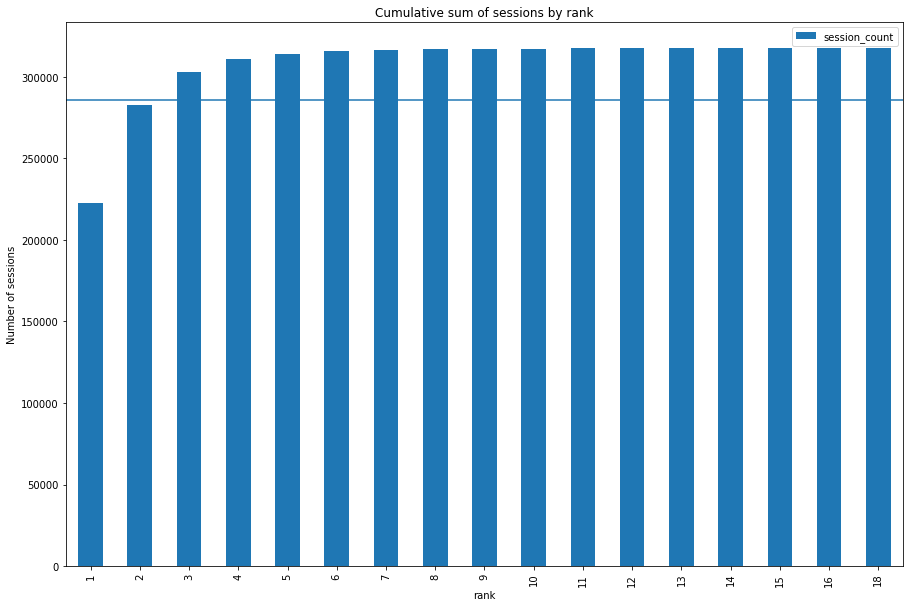

In [21]:
threshold = 0.90

sessions_ranks['session_id'] = sessions_ranks.index
count_by_rank = sessions_ranks.groupby('rank').agg(session_count=('session_id', 'count'))
count_by_rank['session_count'] = count_by_rank["session_count"].cumsum()

count_by_rank.plot(kind='bar', figsize=(15, 10))
plt.axhline(count_by_rank['session_count'].max() * threshold)
plt.ylabel('Number of sessions')
plt.title('Cumulative sum of sessions by rank')

We can see that 90% of the sessions are represented after the third rank, so we don't need to keep data with a rank higher than 3. That means we will only focus our prediction on maximum 3 items visited per session.

Let $k$ be the length we picked for our session, here 3.

In [22]:
k = 3
df_sessions = df_sessions[df_sessions['rank'] <= 3]
df_sessions

,session_id,item_id,date,rank
3893710,3642408,20137,2020-11-15 16:00:06.244,3
3848226,3599296,1481,2021-04-07 16:23:01.167,1
4445981,4162103,24045,2021-03-30 13:15:54.584,1
3375825,3157728,7436,2020-06-15 02:07:35.542,2
538284,503484,4241,2021-05-06 19:21:08.133,2
...,...,...,...,...
1494797,1398710,5458,2020-07-18 06:40:12.993,1
4132174,3865287,14541,2020-06-13 21:53:41.37,3
4709819,4408028,1236,2020-05-13 20:12:15.72,3
4682012,4381298,23465,2020-05-23 07:56:41.821,3


We vectorize our sessions by concatenating the embedding of the corresponding items.

In [23]:
df_sessions = df_sessions.drop(['date', 'rank'], axis=1) \
               .join(embeddings_items, on='item_id', rsuffix='_dup') \
               .set_index('session_id') \
               .sort_index()
df_sessions

,item_id,0,1,2,3,4,5,6,7,8,9,10,11
session_id,,,,,,,,,,,,,
18,2507,2558.514879,-691.736146,35.098254,-347.365313,150.586477,-40.345495,340.349066,-354.621522,-256.759169,-386.076183,-424.796655,211.304232
19,8268,2486.438679,-881.108272,56.129295,-427.000232,-94.961009,-155.386661,-244.370743,-152.797839,-121.634342,-48.565165,490.033120,-111.686946
24,18539,674.229698,698.413943,-1627.522023,-724.695642,-435.772825,148.049470,-80.147118,14.419678,184.790428,71.816486,-37.897240,218.808824
31,26457,2553.443690,-837.775633,111.799787,-396.953732,99.447086,-217.866768,-295.500097,-99.982614,-189.587463,-3.341055,234.246872,-116.954367
42,10395,1700.412343,-140.275622,-360.168860,958.106111,-429.573762,429.892660,-152.410567,566.814356,-517.025974,223.108709,431.685240,-81.772129
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439990,1131,2491.218639,-697.458845,15.040668,66.713279,-286.998094,684.399319,-288.921743,-95.619522,210.894371,316.692554,91.693928,336.421541
4439999,1299,876.551856,666.005869,-1826.477958,-768.100121,-476.467225,3.242425,45.248317,-118.309391,-287.423701,-173.368987,52.354603,-183.881807
4440001,20409,1589.479127,844.476391,81.352742,1066.742716,-306.667970,-313.860733,146.521828,-87.988305,121.339759,-523.941821,224.261422,187.684216


In [24]:
columns = { f'<lambda_{i}>': i + 1 for i in range(k) }
columns

{'<lambda_0>': 1, '<lambda_1>': 2, '<lambda_2>': 3}

Here we retrieve the $k$ (here 3) embedding items features values of the session 

In [25]:
components = [i for i in range(n_components)]
df_sessions = df_sessions.groupby('session_id')[components].agg([
    lambda x: x.iloc[0] if len(x) > 0 else 0.,
    lambda x: x.iloc[1] if len(x) > 1 else 0.,
    lambda x: x.iloc[2] if len(x) > 2 else 0.,
]).rename(columns=columns)

df_sessions

0                                     1               \
                      1            2            3           1           2   
session_id                                                                  
18          2558.514879     0.000000     0.000000 -691.736146    0.000000   
19          2486.438679     0.000000     0.000000 -881.108272    0.000000   
24           674.229698     0.000000     0.000000  698.413943    0.000000   
31          2553.443690     0.000000     0.000000 -837.775633    0.000000   
42          1700.412343     0.000000     0.000000 -140.275622    0.000000   
...                 ...          ...          ...         ...         ...   
4439964     1501.981571     0.000000     0.000000  624.671867    0.000000   
4439986     1433.615883  1492.471577     0.000000   85.169033  185.374747   
4439990     2491.218639     0.000000     0.000000 -697.458845    0.000000   
4439999      876.551856     0.000000     0.000000  666.005869    0.000000   
4440001     1589.479127  1561.838450  1390.672329  844.476391  213.616060   

                                 2                                    3   ...  \
                     3            1           2           3            1  ...   
session_id                                                                ...   
18            0.000000    35.098254    0.000000    0.000000  -347.365313  ...   
19            0.000000    56.129295    0.000000    0.000000  -427.000232  ...   
24            0.000000 -1627.522023    0.000000    0.000000  -724.695642  ...   
31            0.000000   111.799787    0.000000    0.000000  -396.953732  ...   
42            0.000000  -360.168860    0.000000    0.000000   958.106111  ...   
...                ...          ...         ...         ...          ...  ...   
4439964       0.000000  -168.295600    0.000000    0.000000  1091.581095  ...   
4439986       0.000000  -398.672786 -483.283663    0.000000   836.048632  ...   
4439990       0.000000    15.040668    0.000000    0.000000    66.713279  ...   
4439999       0.000000 -1826.477958    0.000000    0.000000  -768.100121  ...   
4440001     130.120389    81.352742 -538.001995 -417.864131  1066.742716  ...   

                   8           9                                   10  \
                    3           1           2           3           1   
session_id                                                              
18           0.000000 -386.076183    0.000000    0.000000 -424.796655   
19           0.000000  -48.565165    0.000000    0.000000  490.033120   
24           0.000000   71.816486    0.000000    0.000000  -37.897240   
31           0.000000   -3.341055    0.000000    0.000000  234.246872   
42           0.000000  223.108709    0.000000    0.000000  431.685240   
...               ...         ...         ...         ...         ...   
4439964      0.000000  -81.902990    0.000000    0.000000  113.698234   
4439986      0.000000 -503.191318 -599.275762    0.000000  215.001139   
4439990      0.000000  316.692554    0.000000    0.000000   91.693928   
4439999      0.000000 -173.368987    0.000000    0.000000   52.354603   
4440001     84.711171 -523.941821 -551.963388 -449.372689  224.261422   

                                            11                          
                     2           3           1           2           3  
session_id                                                              
18            0.000000    0.000000  211.304232    0.000000    0.000000  
19            0.000000    0.000000 -111.686946    0.000000    0.000000  
24            0.000000    0.000000  218.808824    0.000000    0.000000  
31            0.000000    0.000000 -116.954367    0.000000    0.000000  
42            0.000000    0.000000  -81.772129    0.000000    0.000000  
...                ...         ...         ...         ...         ...  
4439964       0.000000    0.000000  294.670944    0.000000    0.000000  
4439986     183.796833    0.000000  226.681723  243.72

In [26]:
df_sessions.columns = df_sessions.columns.to_flat_index()
df_sessions

,"(0, 1)","(0, 2)","(0, 3)","(1, 1)","(1, 2)","(1, 3)","(2, 1)","(2, 2)","(2, 3)","(3, 1)",...,"(8, 3)","(9, 1)","(9, 2)","(9, 3)","(10, 1)","(10, 2)","(10, 3)","(11, 1)","(11, 2)","(11, 3)"
session_id,,,,,,,,,,,,,,,,,,,,,
18,2558.514879,0.000000,0.000000,-691.736146,0.000000,0.000000,35.098254,0.000000,0.000000,-347.365313,...,0.000000,-386.076183,0.000000,0.000000,-424.796655,0.000000,0.000000,211.304232,0.000000,0.000000
19,2486.438679,0.000000,0.000000,-881.108272,0.000000,0.000000,56.129295,0.000000,0.000000,-427.000232,...,0.000000,-48.565165,0.000000,0.000000,490.033120,0.000000,0.000000,-111.686946,0.000000,0.000000
24,674.229698,0.000000,0.000000,698.413943,0.000000,0.000000,-1627.522023,0.000000,0.000000,-724.695642,...,0.000000,71.816486,0.000000,0.000000,-37.897240,0.000000,0.000000,218.808824,0.000000,0.000000
31,2553.443690,0.000000,0.000000,-837.775633,0.000000,0.000000,111.799787,0.000000,0.000000,-396.953732,...,0.000000,-3.341055,0.000000,0.000000,234.246872,0.000000,0.000000,-116.954367,0.000000,0.000000
42,1700.412343,0.000000,0.000000,-140.275622,0.000000,0.000000,-360.168860,0.000000,0.000000,958.106111,...,0.000000,223.108709,0.000000,0.000000,431.685240,0.000000,0.000000,-81.772129,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439964,1501.981571,0.000000,0.000000,624.671867,0.000000,0.000000,-168.295600,0.000000,0.000000,1091.581095,...,0.000000,-81.902990,0.000000,0.000000,113.698234,0.000000,0.000000,294.670944,0.000000,0.000000
4439986,1433.615883,1492.471577,0.000000,85.169033,185.374747,0.000000,-398.672786,-483.283663,0.000000,836.048632,...,0.000000,-503.191318,-599.275762,0.000000,215.001139,183.796833,0.000000,226.681723,243.724187,0.000000
4439990,2491.218639,0.000000,0.000000,-697.458845,0.000000,0.000000,15.040668,0.000000,0.000000,66.713279,...,0.000000,316.692554,0.000000,0.000000,91.693928,0.000000,0.000000,336.421541,0.000000,0.000000


In [27]:
del train_sessions, sessions_ranks

# Embedding purchases
Purchases are one item, so we simply use their embedding. However, we also need to add negative samples so that our model not only learn on positives (One class SVM can do this, but those models are not known to generalize well...). In order to generate negative samples, we shuffle the item_id columns of 4 copies of the purchase array. The original values have a label 1, the copies that have been shuffled have a value of 0.

We drop the `date` column because we don't need it in our studies

In [28]:
train_purchases.drop('date', axis=1, inplace=True)

In [29]:
negative_samples = pd.concat([train_purchases.copy() for _ in range(4)]).reset_index(drop=True)
negative_samples['item_id'] = np.random.permutation(negative_samples['item_id'])
negative_samples['label'] = 0

positive_samples = train_purchases.copy()
positive_samples['label'] = 1

embedding_purchases = pd.concat([positive_samples, negative_samples]).reset_index(drop=True)
embedding_purchases = embedding_purchases.merge(embeddings_items, left_on='item_id', right_index=True)
embedding_purchases.drop('item_id', axis=1, inplace=True)
embedding_purchases

,session_id,label,0,1,2,3,4,5,6,7,8,9,10,11
0,3,1,719.984006,528.835203,-1468.389287,-590.228429,-461.644713,142.297926,11.529499,-86.004784,-204.393971,-149.983850,164.783102,-136.933156
81109,362500,1,719.984006,528.835203,-1468.389287,-590.228429,-461.644713,142.297926,11.529499,-86.004784,-204.393971,-149.983850,164.783102,-136.933156
156247,695904,1,719.984006,528.835203,-1468.389287,-590.228429,-461.644713,142.297926,11.529499,-86.004784,-204.393971,-149.983850,164.783102,-136.933156
208983,931085,1,719.984006,528.835203,-1468.389287,-590.228429,-461.644713,142.297926,11.529499,-86.004784,-204.393971,-149.983850,164.783102,-136.933156
295572,1315209,1,719.984006,528.835203,-1468.389287,-590.228429,-461.644713,142.297926,11.529499,-86.004784,-204.393971,-149.983850,164.783102,-136.933156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998998,4435589,1,900.453529,743.852969,-1572.398614,-649.873817,-118.221318,26.049469,-11.069001,97.029693,141.277512,64.828358,-177.663679,-154.525072
1851195,3779781,0,900.453529,743.852969,-1572.398614,-649.873817,-118.221318,26.049469,-11.069001,97.029693,141.277512,64.828358,-177.663679,-154.525072
2776828,3449251,0,900.453529,743.852969,-1572.398614,-649.873817,-118.221318,26.049469,-11.069001,97.029693,141.277512,64.828358,-177.663679,-154.525072
4591522,2626453,0,900.453529,743.852969,-1572.398614,-649.873817,-118.221318,26.049469,-11.069001,97.029693,141.277512,64.828358,-177.663679,-154.525072


In [30]:
del train_purchases, negative_samples, positive_samples

# Merge everything

We merge the whole dataset together to fit a model. For each session we concatenate:
* The history of the user
* The purchase embedding, with the label

We will have our training set!

In [31]:
df_merged = df_sessions.merge(embedding_purchases, on='session_id', how='inner')
df_merged.head()

,session_id,"(0, 1)","(0, 2)","(0, 3)","(1, 1)","(1, 2)","(1, 3)","(2, 1)","(2, 2)","(2, 3)",...,2,3,4,5,6,7,8,9,10,11
0,18,2558.514879,0.0,0.0,-691.736146,0.0,0.0,35.098254,0.0,0.0,...,860.095832,-592.291207,-244.429482,-147.906782,106.112594,-432.598973,-179.009720,-112.265909,-384.527992,165.714623
1,18,2558.514879,0.0,0.0,-691.736146,0.0,0.0,35.098254,0.0,0.0,...,180.418721,951.358936,-374.655962,-205.072203,57.280994,116.035316,393.430125,-362.581730,102.835106,238.273416
2,18,2558.514879,0.0,0.0,-691.736146,0.0,0.0,35.098254,0.0,0.0,...,79.160903,-248.103511,-61.730480,-188.876977,539.039372,-217.593102,-245.582230,-146.542798,-416.293298,131.892917
3,18,2558.514879,0.0,0.0,-691.736146,0.0,0.0,35.098254,0.0,0.0,...,1509.482626,-252.036541,-1130.754352,233.318732,-62.241818,-215.200234,-105.382597,-262.639902,-205.158080,-155.637557
4,18,2558.514879,0.0,0.0,-691.736146,0.0,0.0,35.098254,0.0,0.0,...,1431.009035,-248.083988,-866.719769,707.772240,-559.167582,-354.178095,90.549207,287.955597,68.588126,444.948475


In [32]:
df_merged.columns

Index(['session_id',       (0, 1),       (0, 2),       (0, 3),       (1, 1),
             (1, 2),       (1, 3),       (2, 1),       (2, 2),       (2, 3),
             (3, 1),       (3, 2),       (3, 3),       (4, 1),       (4, 2),
             (4, 3),       (5, 1),       (5, 2),       (5, 3),       (6, 1),
             (6, 2),       (6, 3),       (7, 1),       (7, 2),       (7, 3),
             (8, 1),       (8, 2),       (8, 3),       (9, 1),       (9, 2),
             (9, 3),      (10, 1),      (10, 2),      (10, 3),      (11, 1),
            (11, 2),      (11, 3),      'label',            0,            1,
                  2,            3,            4,            5,            6,
                  7,            8,            9,           10,           11],
      dtype='object')

In [33]:
X = df_merged.drop(['label', 'session_id'], axis=1)
y = df_merged['label']

In [34]:
def order_by_embedding(X) :
    df = X.reindex(columns = pd.Index([
        (0,1),(1,1),(2,1),(3,1),(4,1),(5,1),(6,1),(7,1),(8,1),(9,1),(10,1),(11,1),
        (0,2),(1,2),(2,2),(3,2),(4,2),(5,2),(6,2),(7,2),(8,2),(9,2),(10,2),(11,2),
        (0,3),(1,3),(2,3),(3,3),(4,3),(5,3),(6,3),(7,3),(8,3),(9,3),(10,3),(11,3),
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
    ]))
    return df

In [35]:
X = order_by_embedding(X)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [37]:
del embedding_purchases

# Recommend items

We pre-compute the embeddings items for the candidates and we stock the embeddings in a dictionnary.

In [38]:
candidates_embeddings = {}
for candidate in tqdm(candidates['item_id']):
    candidates_embeddings[candidate] = embeddings_items.iloc[candidate]

embeddings_items_dict = {}
for item in tqdm(embeddings_items.index):
    embeddings_items_dict[item] = embeddings_items.iloc[item].values

100%|██████████████████████████████████████████████████████████████████████████████████████████| 28144/28144 [00:01<00:00, 18993.74it/s]


In [60]:
def recommend_100_items(model, sessions_items, isRNN=False):
    
    # Get the embedding items features of the training dataset
    s_embedding_items = X_train.copy()[0:0]
    s_embedding_items.loc[0] = 0.
    for i, item in enumerate(sessions_items):
        s_embedding_items.at[0, [(j, i + 1) for j in range(n_components)]] = embeddings_items_dict[item]

    items_proba = {}
    # For each candidate item, recover its embedding and predict the probability of being bought by the session's user.
    for candidate in tqdm(candidates['item_id']):
        if candidate in sessions_items:
            continue
        s_embedding_items.at[0, [i for i in range(n_components)]] = candidates_embeddings[candidate]
        if not isRNN:
            proba = model.predict_proba(s_embedding_items)[0][0]
        else:
            proba = model.predict(s_embedding_items.values.reshape(-1, k+1, n_components))
        items_proba[candidate] = proba

    # Sort the probability of each items and recover the best 100.
    recommended_items = sorted(items_proba.items(), key=lambda d: d[1], reverse=True)[:100]
    return np.array(recommended_items)[:, 0].astype('int32')

In [47]:
del df_merged, df_sessions, X, y

NameError: name 'df_merged' is not defined

# Logistic Regression

We can now directly pass the merged dataset to a LogisticRegression. For the testing part, we perform our prediction on all candidates and pick the hundred ones that have the highest results.

In [48]:
l_regr = LogisticRegression()
l_regr.fit(X_train, y_train)
l_regr.score(X_test, y_test)

0.8007829605828941

In [49]:
# Example
session_items = [5, 100, 420]
recommend_100_items(l_regr, session_items)

array([ 2222, 11006, 17454, 24067, 22931,  5377, 22441, 22146, 22178,
       24881,  8178, 14192, 20165, 15087,  7244, 12127,  2967, 20437,
        9564,  3440,  2429, 13973, 25118, 24123,  2256,  5233,  2831,
       13250, 13273, 19115,   603,  3019, 19987, 19458, 27754, 27974,
       24005, 17065,   720, 16045, 26622,   222,  2998, 12179, 21919,
       16631, 23286, 21185, 11515,  1036,  9411, 24814, 23889,  1968,
       19099,   808,   175,   502,   652, 16776,  9562,  3298, 10625,
       10496, 16139, 18809, 27800,  5288, 11328, 10980, 18061, 21241,
       14214, 27702, 26985, 14596, 19297, 21313, 25083, 16145,  9915,
       25184, 27731, 11689, 18183,  4113,  6871, 13717, 19340, 21116,
       21977, 19955,  8981, 23769, 12282, 17292, 24537, 17057, 17800,
       26796], dtype=int32)

# RNN

Now, let's try to have a RNN running on this dataset.

In [50]:
input_shape = (k+1, 12)

rnn = Sequential()
rnn.add(layers.Masking(mask_value=0, input_shape=input_shape))
rnn.add(layers.LSTM(100,return_sequences=False))
rnn.add(layers.Dense(k, activation='softmax'))

rnn.compile("adam", loss="sparse_categorical_crossentropy", metrics = ["accuracy"])
rnn.summary()

2022-07-17 19:57:50.303725: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-17 19:57:50.303774: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (leme-thinkpad): /proc/driver/nvidia/version does not exist
2022-07-17 19:57:50.304509: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 4, 12)             0         
                                                                 
 lstm (LSTM)                 (None, 100)               45200     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 45,503
Trainable params: 45,503
Non-trainable params: 0
_________________________________________________________________


In [51]:
checkpoint = callbacks.ModelCheckpoint(filepath="model_checkpoint",
                                       monitor ="val_accuracy",
                                       save_best_only = True,
                                       mode='max')

In [54]:
history = rnn.fit(X_train.values.reshape(-1, k+1, n_components),
                  y_train,
                  validation_split=0.2,
                  epochs=3,
                  batch_size=64,
                  callbacks=[checkpoint])
rnn = models.load_model('model_checkpoint')

Epoch 1/3
14216/14216 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.8048

2022-07-17 20:13:48.877874: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


14216/14216 [==============================] - 678s 48ms/step - loss: 0.4480 - accuracy: 0.8048 - val_loss: 0.4379 - val_accuracy: 0.8081
Epoch 2/3
14216/14216 [==============================] - ETA: 0s - loss: 0.4361 - accuracy: 0.8086

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


14216/14216 [==============================] - 698s 49ms/step - loss: 0.4361 - accuracy: 0.8086 - val_loss: 0.4337 - val_accuracy: 0.8085
Epoch 3/3
14215/14216 [============================>.] - ETA: 0s - loss: 0.4324 - accuracy: 0.8106

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


14216/14216 [==============================] - 659s 46ms/step - loss: 0.4324 - accuracy: 0.8106 - val_loss: 0.4337 - val_accuracy: 0.8092


2022-07-17 20:36:37.224107: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-07-17 20:36:37.239765: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-07-17 20:36:37.335217: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-07-17 20:36:37.348982: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-07-17 20:36:37.365547: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_sh

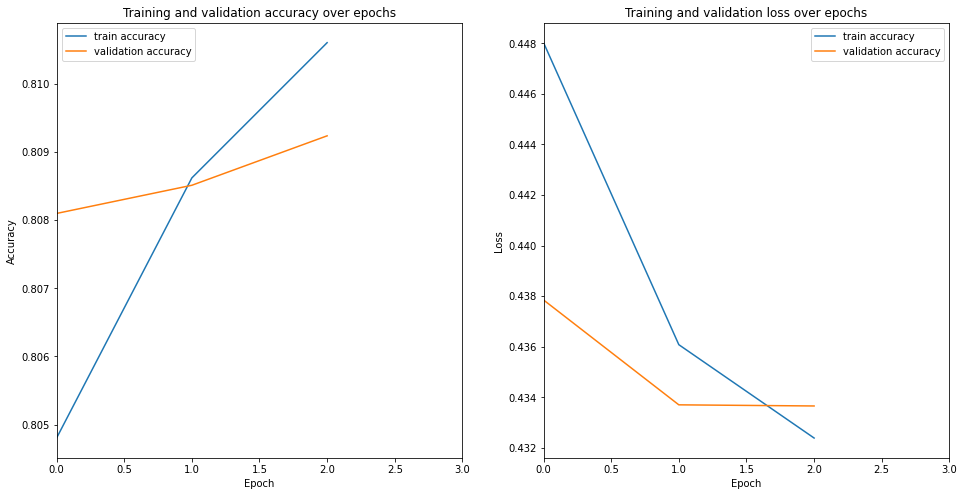

In [55]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim([0, 3])
plt.legend(['train accuracy', 'validation accuracy'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim([0, 3])
plt.legend(['train accuracy', 'validation accuracy'], loc='best')
plt.show()

In [56]:
rnn.evaluate(X_test.values.reshape(-1, k+1, n_components), y_test)

11847/11847 [==============================] - 224s 19ms/step - loss: 0.4335 - accuracy: 0.8109


[0.43348705768585205, 0.8108944296836853]

In [61]:
# Example
session_items = [5, 100, 420]
recommend_100_items(rnn, session_items, isRNN=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4990/4990 [05:18<00:00, 15.66it/s]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Try to reduce the features' number

Let's restart all and reducing the number of features used. Here, we will use the 15 most used features' category of the items, and remove all data with the other features.

In [67]:
items = pd.read_csv('./data/item_features.csv')
train_sessions = pd.read_csv('data/train_sessions.csv', dtype={'session_id': int, 'item_id': int, 'date':object})
train_purchases = pd.read_csv('data/train_purchases.csv', dtype={'session_id': int, 'item_id': int, 'date':object})

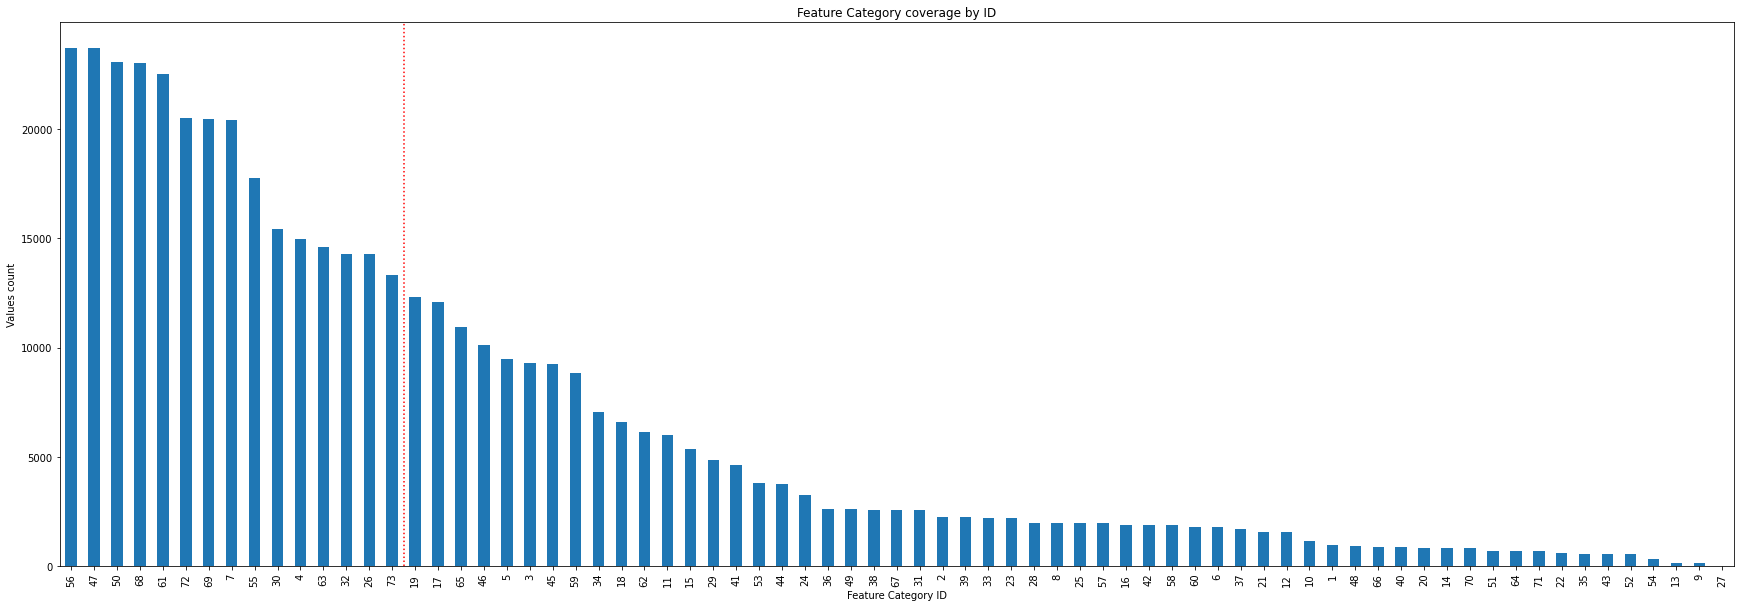

In [68]:
coverage = items['feature_category_id'].sort_values(ascending=False).value_counts(sort=True)
coverage.plot(
    kind='bar',
    figsize=(30, 10),
    xlabel='Feature Category ID',
    ylabel='Values count',
    title='Feature Category coverage by ID')
plt.axvline(x = 14.5, color='r', linestyle='dotted')

In [72]:
items = items[items['feature_category_id'].isin(list(coverage.index[:15]))]
items

,item_id,feature_category_id,feature_value_id
0,2,56,365
2,2,68,351
4,2,72,75
7,2,50,76
8,2,61,462
...,...,...,...
471745,28143,72,371
471746,28143,68,351
471747,28143,55,390
471749,28143,73,91


In [73]:
coo_mat = sparse.coo_matrix((items["feature_value_id"], (items["item_id"], items["feature_category_id"])))
n_components = 12
svd = TruncatedSVD(n_components)
embeddings_items = pd.DataFrame(svd.fit_transform(coo_mat))
del items, coo_mat, svd
df_sessions = train_sessions.sample(frac=0.10)
sessions_ranks = df_sessions.groupby('session_id').agg(rank=('item_id', 'count'))
df_sessions = df_sessions.join(sessions_ranks, on='session_id', rsuffix='_dup')
k = 3
df_sessions = df_sessions[df_sessions['rank'] <= 3]
df_sessions = df_sessions.drop(['date', 'rank'], axis=1) \
               .join(embeddings_items, on='item_id', rsuffix='_dup') \
               .set_index('session_id') \
               .sort_index()
columns = { f'<lambda_{i}>': i + 1 for i in range(k) }
components = [i for i in range(n_components)]
df_sessions = df_sessions.groupby('session_id')[components].agg([
    lambda x: x.iloc[0] if len(x) > 0 else 0.,
    lambda x: x.iloc[1] if len(x) > 1 else 0.,
    lambda x: x.iloc[2] if len(x) > 2 else 0.,
]).rename(columns=columns)
df_sessions.columns = df_sessions.columns.to_flat_index()
del train_sessions, sessions_ranks
train_purchases.drop('date', axis=1, inplace=True)
negative_samples = pd.concat([train_purchases.copy() for _ in range(4)]).reset_index(drop=True)
negative_samples['item_id'] = np.random.permutation(negative_samples['item_id'])
negative_samples['label'] = 0

positive_samples = train_purchases.copy()
positive_samples['label'] = 1

embedding_purchases = pd.concat([positive_samples, negative_samples]).reset_index(drop=True)
embedding_purchases = embedding_purchases.merge(embeddings_items, left_on='item_id', right_index=True)
embedding_purchases.drop('item_id', axis=1, inplace=True)
del train_purchases, negative_samples, positive_samples
df_merged = df_sessions.merge(embedding_purchases, on='session_id', how='inner')
df_merged.head()
X = df_merged.drop(['label', 'session_id'], axis=1)
y = df_merged['label']
X = order_by_embedding(X)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [75]:
l_regr_v2 = LogisticRegression()
l_regr_v2.fit(X_train, y_train)
l_regr_v2.score(X_test, y_test)

0.7988473306604769

In [76]:
input_shape = (k+1, 12)

rnn_v2 = Sequential()
rnn_v2.add(layers.Masking(mask_value=0, input_shape=input_shape))
rnn_v2.add(layers.LSTM(100,return_sequences=False))
rnn_v2.add(layers.Dense(k, activation='softmax'))

rnn_v2.compile("adam", loss="sparse_categorical_crossentropy", metrics = ["accuracy"])
checkpoint = callbacks.ModelCheckpoint(filepath="model_checkpoint",
                                       monitor ="val_accuracy",
                                       save_best_only = True,
                                       mode='max')

history = rnn_v2.fit(X_train.values.reshape(-1, k+1, n_components),
                  y_train,
                  validation_split=0.2,
                  epochs=3,
                  batch_size=64,
                  callbacks=[checkpoint])
rnn_v2 = models.load_model('model_checkpoint')
rnn_v2.evaluate(X_test.values.reshape(-1, k+1, n_components), y_test)

Epoch 1/3
  268/14217 [..............................] - ETA: 8:22 - loss: 0.5561 - accuracy: 0.7854WARNING:tensorflow:Gradients do not exist for variables ['dense_1/kernel:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?


  914/14217 [>.............................] - ETA: 8:18 - loss: 0.5051 - accuracy: 0.7963

KeyboardInterrupt: 

# LeaderBoard

Here we can compute the prediction used for the leaderboard of RecSys challenge.

In [37]:
def compute_full_leaderboard(model, isKNN=False):
    rows = []
    leaderboard_sessions_dict = test_leaderboard_sessions.groupby('session_id')['item_id'].agg(list).to_dict()
    for session_id, session_items in tqdm(leaderboard_sessions_dict.items()):
        recommended_items = recommend_100_items(session_items[:k], isKNN)
        rows += [(session_id, item_id, i + 1) for i, item_id in enumerate(recommended_items)]
    res = pd.DataFrame(rows, columns=['session_id', 'item_id', 'rank'])
    res.to_csv(os.path.join(data_dir, 'recsys_prediction.csv'),index=False)

To reduce the complexity of the computation, we have only worked on the 150 most popular items in the `train_sessions` dataset.

In [ ]:
train_sessions = pd.read_csv('data/train_sessions.csv', dtype={'session_id': int, 'item_id': int, 'date':object})

In [ ]:
most_popular_items = list(train_sessions['item_id'] \
                .value_counts() \
                .reset_index() \
                .sort_values('item_id', ascending=False)['index'])[:150]
candidates = candidates[candidates['item_id'].isin(most_popular_items)

In [ ]:
compute_full_leaderboard(l_regr)